**In this notebook, we will:**

1. Load a time-series dataset into a pandas DataFrame.
2. Clean and explore the data.
3. Visualize the raw signal.
4. Perform a Fast Fourier Transform (FFT) to move from time domain to frequency domain.
5. Extract key frequency-domain analytics (dominant frequencies, power spectrum, etc.).
6. Optionally design a simple filter and reconstruct the signal via inverse FFT.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import detrend

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load the data

We will:

- Load a CSV file containing time-series data.
- Assume:
  - `time` column: either numeric (seconds) or a timestamp.
  - `value` column: the signal we want to analyze.

If you don't have a dataset yet, you can use the synthetic signal generator cell below as a fallback.


In [2]:
# TODO: Update this path to your actual dataset on Kaggle
DATA_PATH = "/kaggle/input/timeseries-weather-dataset/Weather_Data_1980_2024(hourly).csv"

df = pd.read_csv(DATA_PATH)

df.head()


,time,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
0,1980-01-01T00:00,12.7,83,10.0,0.0,0.0,0,1012.8,945.1,1,1,0,0,0.25,7.5,235,0
1,1980-01-01T01:00,12.9,82,9.9,0.0,0.0,0,1012.2,944.5,4,4,0,0,0.26,7.9,231,0
2,1980-01-01T02:00,13.2,82,10.2,0.0,0.0,0,1012.3,944.7,13,14,0,0,0.27,7.5,235,1
3,1980-01-01T03:00,15.9,78,12.0,0.0,0.0,0,1013.5,946.4,23,26,0,0,0.40,6.6,248,1
4,1980-01-01T04:00,19.4,67,13.1,0.0,0.0,0,1014.6,948.2,9,10,0,0,0.75,8.7,265,1


## 2. Clean data and compute sampling frequency

- Convert `time` to numeric seconds (if it's a timestamp).
- Sort by time.
- Remove duplicates and missing values.
- Compute the effective sampling frequency `fs`.


In [7]:
df = df.copy()

# Drop rows with missing values in critical columns
df = df.dropna(subset=["time", "temperature"])

# If 'time' is datetime-like, convert to seconds relative to start
if not np.issubdtype(df["time"].dtype, np.number):
    df["time"] = pd.to_datetime(df["time"])
    # convert to seconds from first timestamp
    df["time"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds()

# Sort by time just in case
df = df.sort_values("time").reset_index(drop=True)

# Remove duplicate time stamps
df = df.drop_duplicates(subset="time")

# Compute sampling interval, assume (approx) uniform sampling
dt = df["time"].diff().dropna()
median_dt = dt.median()
fs = 1.0 / median_dt

print(f"Approx. sampling interval dt = {median_dt:.6f} s")
print(f"Approx. sampling frequency fs = {fs:.2f} Hz")

df.head()


Approx. sampling interval dt = 3600.000000 s
Approx. sampling frequency fs = 0.00 Hz


,time,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
0,0.0,12.7,83,10.0,0.0,0.0,0,1012.8,945.1,1,1,0,0,0.25,7.5,235,0
1,3600.0,12.9,82,9.9,0.0,0.0,0,1012.2,944.5,4,4,0,0,0.26,7.9,231,0
2,7200.0,13.2,82,10.2,0.0,0.0,0,1012.3,944.7,13,14,0,0,0.27,7.5,235,1
3,10800.0,15.9,78,12.0,0.0,0.0,0,1013.5,946.4,23,26,0,0,0.40,6.6,248,1
4,14400.0,19.4,67,13.1,0.0,0.0,0,1014.6,948.2,9,10,0,0,0.75,8.7,265,1


## 3. Visualize the raw time-domain signal

A quick plot to check:

- Any obvious trends or drift
- Level of noise
- Presence of periodic patterns by eye


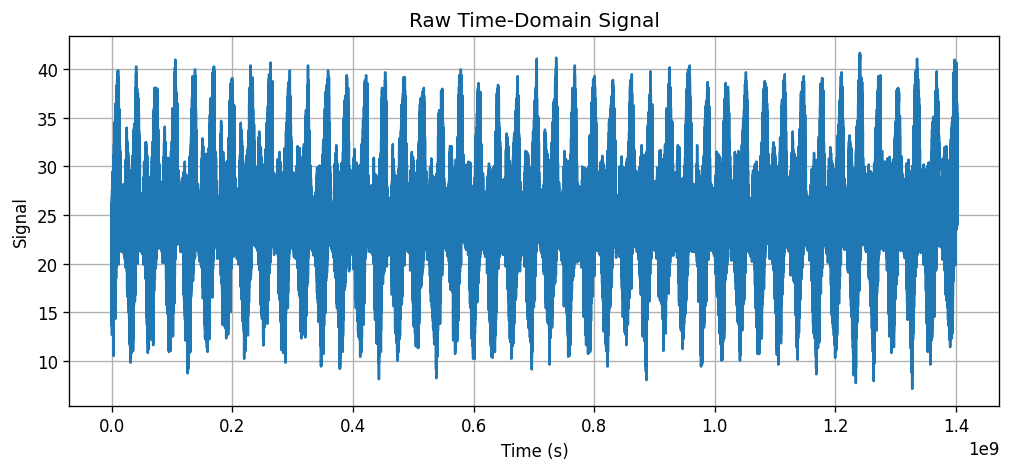

In [8]:
time = df["time"].values
x = df["temperature"].values

plt.figure()
plt.plot(time, x)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Raw Time-Domain Signal")
plt.show()


## 4. Detrend and preprocess

Many real signals have slow trends (e.g., drift).  
These can smear energy into low frequencies in the FFT.

We'll:

- Detrend the signal.
- Optionally window it later if needed.


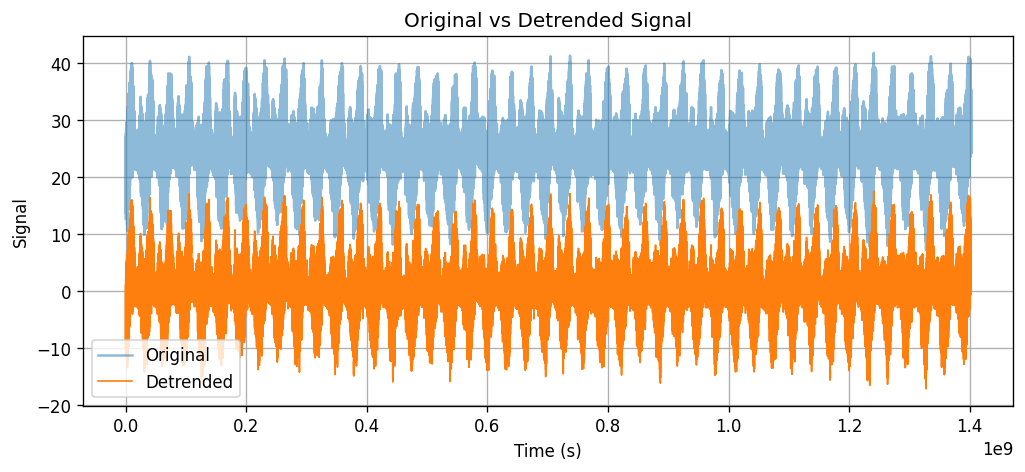

In [9]:
# Detrend the signal to remove linear trend
x_detrended = detrend(x, type="linear")

plt.figure()
plt.plot(time, x, label="Original", alpha=0.5)
plt.plot(time, x_detrended, label="Detrended", linewidth=1.0)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Original vs Detrended Signal")
plt.legend()
plt.show()


## 5. Fast Fourier Transform (FFT)

We now transform the detrended signal from the time domain to the frequency domain:

- We use the real FFT (`rfft`), which returns frequencies from 0 Hz up to the Nyquist frequency (`fs/2`).
- We compute the **amplitude spectrum** and **power spectrum**.

Key values:

- `N`: number of samples
- `fs`: sampling frequency
- `freqs`: corresponding frequencies for each FFT bin


In [10]:
N = len(x_detrended)

# Frequency bins corresponding to rfft
freqs = rfftfreq(N, d=1.0/fs)

# Compute FFT (complex values)
X = rfft(x_detrended)

# Amplitude spectrum (magnitude)
amplitude = np.abs(X)

# Power spectrum (magnitude squared)
power = amplitude**2

print(f"Number of samples: {N}")
print(f"Max frequency (Nyquist): {freqs.max():.2f} Hz")


Number of samples: 389496
Max frequency (Nyquist): 0.00 Hz


## 6. Visualize amplitude and power spectrum

We'll plot:

1. Amplitude spectrum (|X(f)|).
2. Power spectrum (|X(f)|²).

We might also zoom in on a smaller frequency range to see the main peaks clearly.


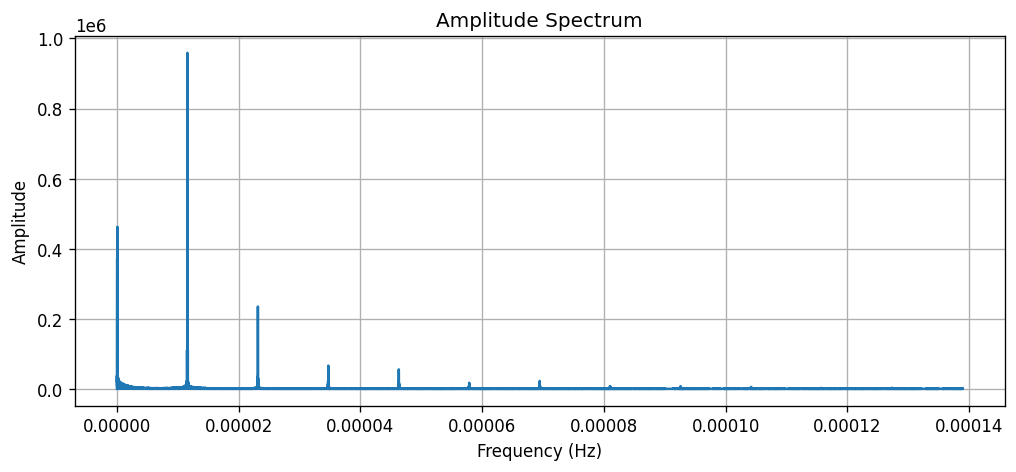

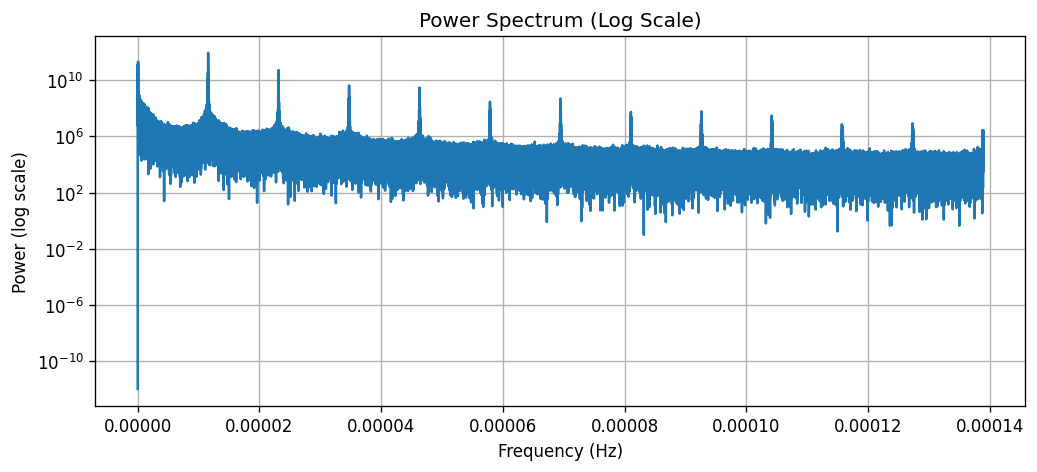

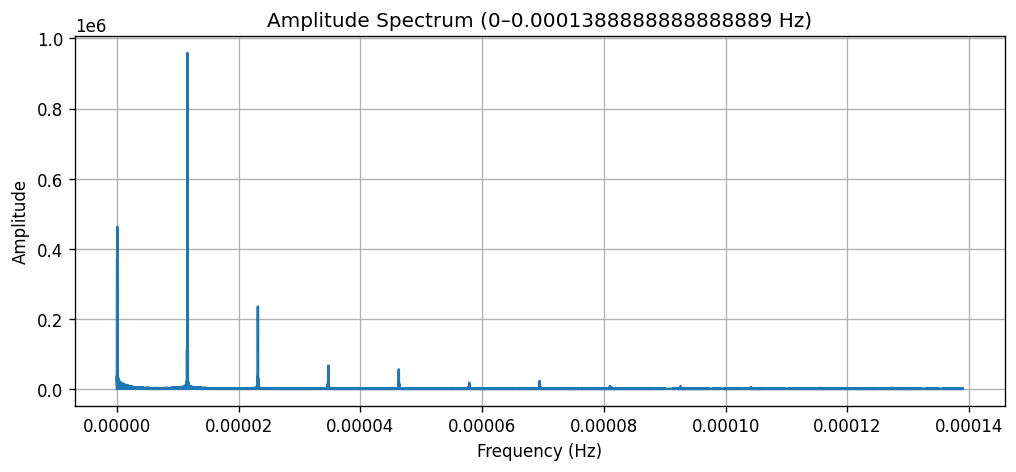

In [11]:
# Full-range amplitude spectrum
plt.figure()
plt.plot(freqs, amplitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Amplitude Spectrum")
plt.show()

# Full-range power spectrum (log scale for better visibility)
plt.figure()
plt.semilogy(freqs, power + 1e-12)  # add small epsilon to avoid log(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (log scale)")
plt.title("Power Spectrum (Log Scale)")
plt.show()

# Zoom on low-frequency region (most signals of interest)
max_freq_zoom = min(50, freqs.max())  # e.g., 0-50 Hz
mask_zoom = freqs <= max_freq_zoom

plt.figure()
plt.plot(freqs[mask_zoom], amplitude[mask_zoom])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"Amplitude Spectrum (0–{max_freq_zoom} Hz)")
plt.show()


## 7. Frequency-domain analytics

We extract:

- **Dominant frequency**: the frequency with maximum amplitude (excluding DC if needed).
- **Top-k peaks**: list of frequencies with highest amplitude.
- **Spectral centroid**: "center of mass" in frequency domain.


In [13]:
# Ignore DC component (0 Hz) when searching for dominant non-DC frequency
amplitude_no_dc = amplitude.copy()
if len(amplitude_no_dc) > 0:
    amplitude_no_dc[0] = 0.0

# Dominant frequency
idx_dom = np.argmax(amplitude_no_dc)
dom_freq = freqs[idx_dom]
dom_amp = amplitude_no_dc[idx_dom]

print(f"Dominant non-DC frequency: {dom_freq:.3f} Hz (amplitude = {dom_amp:.4f})")

# Top-k peaks
k = 5
top_indices = np.argsort(amplitude_no_dc)[-k:][::-1]
top_freqs = freqs[top_indices]
top_amps = amplitude_no_dc[top_indices]

print("\nTop frequency peaks:")
for i, (f, a) in enumerate(zip(top_freqs, top_amps), start=1):
    print(f"{i}) {f:.3f} Hz – amplitude {a:.4f}")

# Spectral centroid (simple version)
spectral_centroid = np.sum(freqs * amplitude) / np.sum(amplitude)
print(f"\nSpectral centroid: {spectral_centroid:.3f} Hz")


Dominant non-DC frequency: 0.000 Hz (amplitude = 958759.7802)

Top frequency peaks:
1) 0.000 Hz – amplitude 958759.7802
2) 0.000 Hz – amplitude 462346.7503
3) 0.000 Hz – amplitude 372323.9381
4) 0.000 Hz – amplitude 272042.5074
5) 0.000 Hz – amplitude 234862.6916

Spectral centroid: 0.000 Hz


## 8. Simple frequency-domain filtering (optional)

We can perform naive filtering in the frequency domain by:

- Zeroing out FFT coefficients outside a desired band.
- Applying inverse FFT (`irfft`) to reconstruct the filtered time-domain signal.

Examples:

- **Low-pass filter**: keep only frequencies below a cutoff `f_c`.
- **High-pass filter**: keep only frequencies above `f_c`.


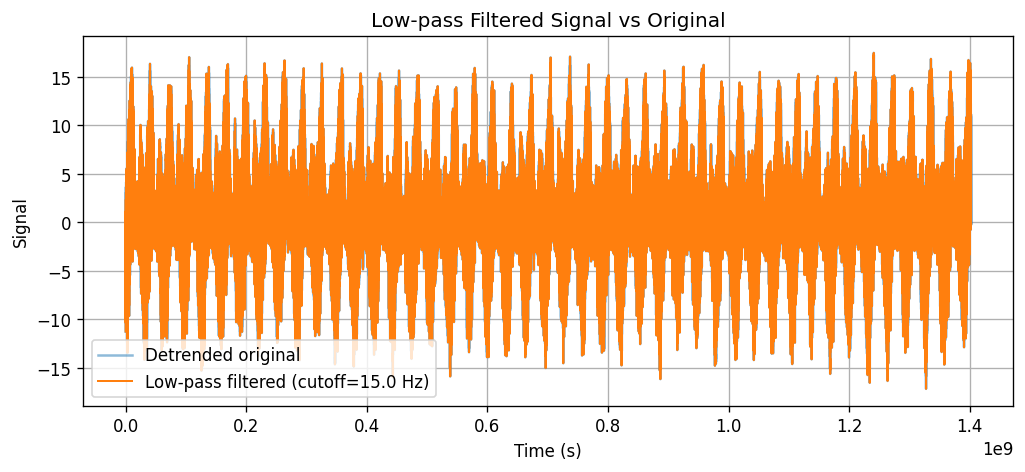

In [14]:
# Define a low-pass cutoff frequency
cutoff_lowpass = 15.0  # Hz, adjust as needed

# Copy the FFT coefficients
X_lowpass = X.copy()

# Zero out frequencies above cutoff
mask_lowpass = freqs > cutoff_lowpass
X_lowpass[mask_lowpass] = 0

# Inverse FFT to reconstruct time-domain signal
x_lowpass = irfft(X_lowpass, n=N)

plt.figure()
plt.plot(time, x_detrended, label="Detrended original", alpha=0.5)
plt.plot(time, x_lowpass, label=f"Low-pass filtered (cutoff={cutoff_lowpass} Hz)", linewidth=1.2)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Low-pass Filtered Signal vs Original")
plt.legend()
plt.show()


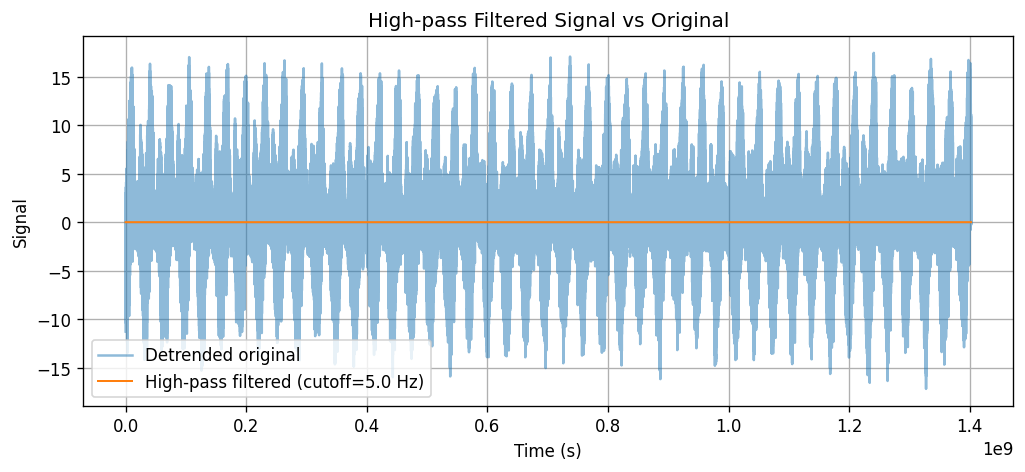

In [15]:
# Define a high-pass cutoff frequency
cutoff_highpass = 5.0  # Hz, adjust as needed

X_highpass = X.copy()

# Zero out frequencies below cutoff (including DC)
mask_highpass = freqs < cutoff_highpass
X_highpass[mask_highpass] = 0

x_highpass = irfft(X_highpass, n=N)

plt.figure()
plt.plot(time, x_detrended, label="Detrended original", alpha=0.5)
plt.plot(time, x_highpass, label=f"High-pass filtered (cutoff={cutoff_highpass} Hz)", linewidth=1.2)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("High-pass Filtered Signal vs Original")
plt.legend()
plt.show()


## 9. Summary & next steps

In this notebook we:

- Cleaned a time-series dataset and inferred its sampling frequency.
- Visualized the raw and detrended signals.
- Applied FFT to move into the frequency domain.
- Inspected amplitude and power spectra.
- Extracted dominant frequencies and spectral metrics (top peaks, spectral centroid).
- Performed simple low-pass and high-pass filtering with inverse FFT reconstruction.

**Ideas to extend this analysis:**

- Use windowing (e.g., Hanning) before FFT to reduce spectral leakage.
- Compute Short-Time Fourier Transform (STFT) to see how frequencies evolve over time.
- Compare spectra across multiple signals or segments (e.g., before/after an event).
- Automate detection of significant peaks and link them to real-world phenomena in your data.
